In [396]:
#librerias base
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
import os,glob
import cv2
from sklearn import preprocessing
import datetime
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import figure
from kerastuner.tuners import BayesianOptimization

#keras - tensorflow
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten

In [33]:
#Carga de datos
df_train = pd.read_csv('./train.csv')
consumo_train = df_train
df_test = pd.read_csv('./test.csv')
consumo_test = df_test

In [30]:
consumo_data.tail()

,FechaEmision,ConsumoKW
67,2017-08-09,303
68,2017-09-08,313
69,2017-10-10,297
70,2017-11-08,303
71,2017-12-09,313


In [34]:
#Convertir a serie de tiempo
consumo_train["FechaEmision"] = pd.to_datetime(consumo_train["FechaEmision"], dayfirst=True)
consumo_test["FechaEmision"] = pd.to_datetime(consumo_test["FechaEmision"], dayfirst=True)

<AxesSubplot:title={'center':'Entrenamiento 2012-2017'}, xlabel='FechaEmision'>

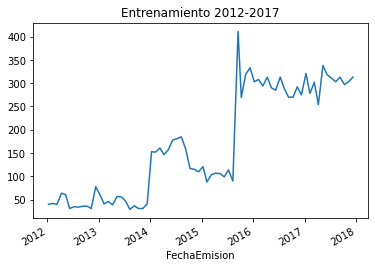

In [38]:
#Gráfica de serie de tiempo
plt.title('Entrenamiento 2012-2017')
consumo_train.set_index('FechaEmision')['ConsumoKW'].plot()

<AxesSubplot:title={'center':'Test 2018'}, xlabel='FechaEmision'>

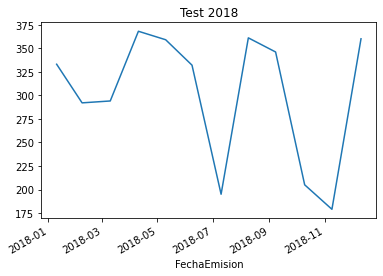

In [36]:
plt.title('Test 2018')
consumo_test.set_index('FechaEmision')['ConsumoKW'].plot()

In [76]:
#Función que crea la matriz que alimenta la red LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [158]:
np.random.seed(7)

In [332]:
#Separar valores de consumo
data_train = consumo_train["ConsumoKW"]
data_test = consumo_test["ConsumoKW"]

In [333]:
data_train = np.squeeze(np.asarray(data_train))
data_test = np.squeeze(np.asarray(data_test))

In [334]:
data = np.hstack((data_train,data_test))

In [335]:
#Escalar datos
scaler = MinMaxScaler()
dataset = scaler.fit_transform(data.reshape(-1,1))

In [336]:
#Dividir datos
train, test = dataset[0:-12,:], dataset[-12:,:]

In [526]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [527]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Modelo

In [525]:
rnn = keras.Sequential([
    layers.LSTM(256,input_dim=look_back),
    layers.Dense(1,activation='sigmoid')
])

In [528]:
#Compilación de modelo
rnn.compile(loss="mean_squared_error",
              optimizer="adam",
           metrics = ['MSE'])

In [529]:
#Creación de checkpoint
filepath="./Parte3.weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='MSE', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [530]:
#Entrenamiento
rnn.fit(trainX, trainY, batch_size=1, epochs=100, callbacks=callbacks_list, verbose=2)

Epoch 1/100

Epoch 1: MSE improved from -inf to 0.10176, saving model to .\Parte3.weights.best.hdf5
70/70 - 1s - loss: 0.1018 - MSE: 0.1018 - 1s/epoch - 16ms/step
Epoch 2/100

Epoch 2: MSE did not improve from 0.10176
70/70 - 0s - loss: 0.0790 - MSE: 0.0790 - 127ms/epoch - 2ms/step
Epoch 3/100

Epoch 3: MSE did not improve from 0.10176
70/70 - 0s - loss: 0.0501 - MSE: 0.0501 - 145ms/epoch - 2ms/step
Epoch 4/100

Epoch 4: MSE did not improve from 0.10176
70/70 - 0s - loss: 0.0290 - MSE: 0.0290 - 189ms/epoch - 3ms/step
Epoch 5/100

Epoch 5: MSE did not improve from 0.10176
70/70 - 0s - loss: 0.0203 - MSE: 0.0203 - 128ms/epoch - 2ms/step
Epoch 6/100

Epoch 6: MSE did not improve from 0.10176
70/70 - 0s - loss: 0.0179 - MSE: 0.0179 - 118ms/epoch - 2ms/step
Epoch 7/100

Epoch 7: MSE did not improve from 0.10176
70/70 - 0s - loss: 0.0173 - MSE: 0.0173 - 123ms/epoch - 2ms/step
Epoch 8/100

Epoch 8: MSE did not improve from 0.10176
70/70 - 0s - loss: 0.0172 - MSE: 0.0172 - 121ms/epoch - 2ms/st

In [531]:
#Predicciones
trainPredict = rnn.predict(trainX)
testPredict = rnn.predict(testX)

1/1 [==============================] - 0s 18ms/step


In [532]:
# Revertir predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Train Score: 46.44 RMSE
Test Score: 77.62 RMSE


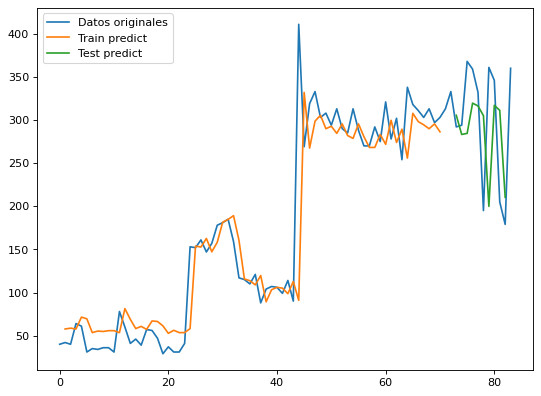

In [533]:
# Calcular metricas
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Graficar datos originales y predicciones
figure(figsize=(8, 6), dpi=80)
plt.plot(scaler.inverse_transform(dataset),label='Datos originales')
plt.plot(trainPredictPlot,label='Train predict')
plt.plot(testPredictPlot, label='Test predict')
plt.legend(loc="upper left")
plt.show()

In [437]:
#Metricas
res_dict_tree = defaultdict(lambda: "Not present")
res_dict_tree["RMSE_train"] = trainScore
res_dict_tree["RMSE_test"] = testScore
ss = SummaryString(model)
bitacora(ss,res_dict_tree)

# Bayesian Optimization
Realizando una investigación para mejorar las métricas de la red LSTM, encontre información de la aplicación del teorema de bayes para encontrar los valores minimos y máximos referente al número de capas de una red LTSM, se realizó la implementación por motivos complementarios.

In [509]:
n_input = 1
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units',min_value=32,
                                    max_value=512,
                                    step=32), 
               activation='relu', input_shape=(n_input, 1)))
    #model.add(Dense(units=hp.Int('units',min_value=32,
    #                               max_value=512,
    #                                step=32), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_squared_error', metrics=['mse'], optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate',
                  values=[1e-2, 1e-3, 1e-4])))
    return model

bayesian_opt_tuner = BayesianOptimization(
    build_model,
    objective='mse',
    max_trials=3,
    executions_per_trial=1,
    directory=os.path.normpath('C:/keras_tuning'),
    project_name='kerastuner_bayesian_poc',
    overwrite=True)

bayesian_opt_tuner.search(trainX, trainY,epochs=100,verbose=1)


bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model[0]

Trial 3 Complete [00h 00m 06s]
mse: 0.013982743956148624

Best mse So Far: 0.013982743956148624
Total elapsed time: 00h 00m 15s
INFO:tensorflow:Oracle triggered exit


In [510]:
#Entrenamiento
model.fit(trainX, trainY, batch_size=1, epochs=100, verbose=2)

Epoch 1/100
70/70 - 1s - loss: 0.0182 - mse: 0.0182 - 1s/epoch - 17ms/step
Epoch 2/100
70/70 - 1s - loss: 0.0186 - mse: 0.0186 - 578ms/epoch - 8ms/step
Epoch 3/100
70/70 - 1s - loss: 0.0159 - mse: 0.0159 - 605ms/epoch - 9ms/step
Epoch 4/100
70/70 - 0s - loss: 0.0165 - mse: 0.0165 - 473ms/epoch - 7ms/step
Epoch 5/100
70/70 - 0s - loss: 0.0171 - mse: 0.0171 - 477ms/epoch - 7ms/step
Epoch 6/100
70/70 - 0s - loss: 0.0164 - mse: 0.0164 - 485ms/epoch - 7ms/step
Epoch 7/100
70/70 - 0s - loss: 0.0164 - mse: 0.0164 - 479ms/epoch - 7ms/step
Epoch 8/100
70/70 - 0s - loss: 0.0142 - mse: 0.0142 - 478ms/epoch - 7ms/step
Epoch 9/100
70/70 - 0s - loss: 0.0192 - mse: 0.0192 - 485ms/epoch - 7ms/step
Epoch 10/100
70/70 - 1s - loss: 0.0173 - mse: 0.0173 - 525ms/epoch - 8ms/step
Epoch 11/100
70/70 - 1s - loss: 0.0171 - mse: 0.0171 - 514ms/epoch - 7ms/step
Epoch 12/100
70/70 - 0s - loss: 0.0161 - mse: 0.0161 - 475ms/epoch - 7ms/step
Epoch 13/100
70/70 - 0s - loss: 0.0163 - mse: 0.0163 - 475ms/epoch - 7ms/st

1/1 [==============================] - 0s 16ms/step
Train Score: 42.55 RMSE
Test Score: 76.32 RMSE


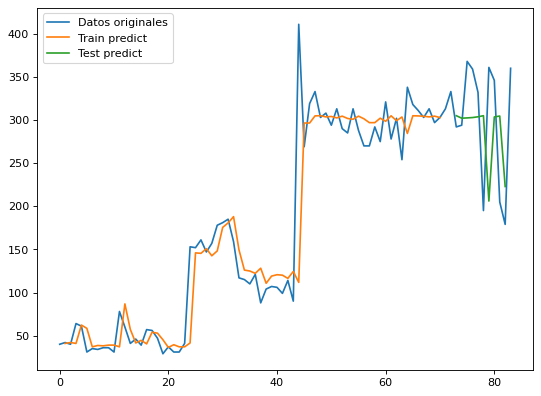

In [511]:
#Predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Revertir predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calcular metricas
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Graficar datos originales y predicciones
figure(figsize=(8, 6), dpi=80)
plt.plot(scaler.inverse_transform(dataset),label='Datos originales')
plt.plot(trainPredictPlot,label='Train predict')
plt.plot(testPredictPlot, label='Test predict')
plt.legend(loc="upper left")
plt.show()

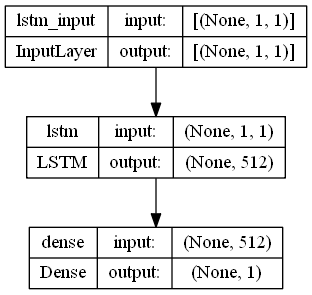

In [512]:
plot_model(model, to_file='Parte3BayesOpt.png', show_shapes=True, show_layer_names=True)

# Conclusiones

Luego de realizar distintos experimentos, adjuntos en archivo Bitacora.csv, se establecio una red neural recurrente de tipo LSTM con 1 capa LSTM y una capa densa.

Adjunto diagrama final de modelo.


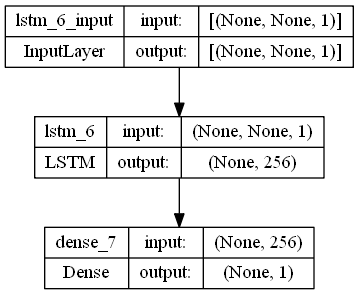

In [505]:
plot_model(rnn, to_file='Parte3.png', show_shapes=True, show_layer_names=True)

# Publicación
El proceso de publicación de la red entrenada a produción se puede realizar guardando los pesos de la red en un archivo ***HDF5***, formato utilizado por Keras.

Para realizar un despliegue por ejemplo a una página web, se puede usar un framework muy liviando de frontend para utlizar python como backend, según la investigación realizada ***Flask*** es la herramienta utilizada generalmente.